# **Preprocsessing Phase**

In [1]:
import numpy as np
import pandas as pd
import librosa
import math
import os
from librosa.effects import trim
from pydub import AudioSegment
import soundfile as sf
from transformers import pipeline
import shutil
import matplotlib.pyplot as plt
import random
from IPython.display import Audio, display
from sklearn.utils import resample
from tensorflow.keras import layers
from tensorflow.keras import models
import keras.backend as K
import copy
import shutil
from sklearn.utils import resample
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from keras import layers
from keras import models
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from keras.utils import to_categorical
import tensorflow.keras.layers as Lhhyyt
import tensorflow as tf
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns

In [4]:
def spectral_subtraction(audio, noise_threshold, alpha):
    audio_stft = librosa.stft(audio, n_fft = 2048, hop_length = 512)

    noise_stft = np.median(np.abs(audio_stft), axis = 1)
    noise_stft= np.expand_dims(noise_stft, axis = 1)

    audio_power = np.abs(audio_stft)**2
    cleaned_power = audio_power - alpha * noise_stft
    cleaned_power[cleaned_power < noise_threshold] = noise_threshold

    cleaned_stft = np.sqrt(cleaned_power) * np.exp(1j * np.angle(audio_stft))
    cleaned_audio = librosa.istft(cleaned_stft, hop_length=512)

    return cleaned_audio 

In [5]:
def remove_silence(audio_data):
    audio_data_trimmed, _ = trim(audio_data, top_db=20)
    return audio_data_trimmed

In [6]:
def normalize_audio(audio):
    audio_mean = np.mean(audio)
    audio_std = np.std(audio)

    if audio_std == 0:
        audio_std = 1e-6
    normalized_audio = (audio - audio_mean) / audio_std

    return normalized_audio

In [7]:
def preemphasis(signal, alpha):
    preemphasized_signal = signal - alpha * np.append(signal[0], signal[:-1])
    return preemphasized_signal

In [8]:
def truncate_pad(audio_data, desired_duration):
    num_samples = int(desired_duration * 16000)
    if len(audio_data) > num_samples:
        audio_data = audio_data[:num_samples]
    else:
        audio_data = np.pad(audio_data, (0, num_samples - len(audio_data)), 'constant')
    
    return audio_data

In [10]:
def preprocess_audio(audio_data, sr):
    cleaned_audio = spectral_subtraction(audio_data, 0.000000005, 3)
    silenced = remove_silence(cleaned_audio)
    preemphasized = preemphasis(silenced, 0.95)
    normalized_data = normalize_audio(preemphasized)
    preprocessed_audio = truncate_pad(normalized_data, 3)
    
    return preprocessed_audio

# **Extracting features** 

### Frequency Features

In [11]:
def extract_featuresFreq(data, sr, frame_len, hop_length):
    # ZCR
    result = np.array([])
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y = data, sr = sr).T, axis = 0)
    result = np.hstack((result, mfcc))
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y = data, sr = sr).T, axis = 0)
    result = np.hstach((result, mel))

    return result

### Time Features
- Zero Crossing Rate
- Energy
- Root Mean Square Energy(RMSE)
- Pitch Contour
- Mel-Frequenct Cepstral Coefficients(MFCCs)
- SPC, SPC rolloff

In [12]:
def zero_crossing_rate(data, non_overlapping_period):
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y = data, hop_length = non_overlapping_period)

    return np.squeeze(zero_crossing_rate)

In [13]:
def energy(data, frame_len, non_overlapping_period):
    en = np.array([np.sum(np.power(np.abs(data[non_overlapping_period:non_overlapping_period + frame_len]), 2)) for hop in range(0, data.shape[0], non_overlapping_period)])

    return en/frame_len

In [14]:
def entropy_of_energy(data, frame_len, non_overlapping_period):
    energies = energy(data, frame_len, non_overlapping_period)
    sum = np.sum(energies)
    if sum == 0:
        sum = 1e-6
    energies /= sum
    entropy = 0.0
    energies_nonzeros = np.where(energies == 0, 1, energies)
    entropy -= energies_nonzeros * np.log2(energies_nonzeros)

    return entropy


In [15]:
def rmse(data, non_overlapping_period):
    rmse = librosa.feature.rms(y = data, hop_length = non_overlapping_period)

    return np.squeeze(rmse)

In [16]:
def get_pitch_contour(data, sr, frame_len, hop_length):
    f0, voiced_flag, voiced_probs = librosa.pyin(data, fmin = 75, fmax = 300)
    pitch_mean = np.mean(f0[voiced_flag])
    pitch_std = np.std(f0[voiced_flag])
    if math.isnan(pitch_std):
        pitch_std = 0
    if math.isnan(pitch_mean):
        pitch_mean = 0
    return pitch_mean, pitch_std

In [17]:
def mfcc(data, frame_len, hop_length, sr):
    frame_rate = 100
    mfcc_feature = librosa.feature.mfcc(y = data, n_fft = frame_len, sr = sr, hop_length = int(sr/frame_rate), n_mfcc = 13)
    return np.squeeze(mfcc_feature).flatten()

In [18]:
def spc(data, sr, frame_len, non_overlapping_period):
    spectral_centroid = librosa.feature.spectral_centroid(y = data, sr = sr, n_fft= frame_len, hop_length=non_overlapping_period)
    return np.squeeze(spectral_centroid)

In [19]:
def spc_rollof(data, sr, frame_len, non_overlappibg_period):
    spcrollof = librosa.feature.spectral_rolloff(y = data, sr = sr, n_fft=frame_len, hop_length=non_overlappibg_period)
    return np.squeeze(spc_rollof)

In [20]:
def extract_features(data, sr, frame_len, hop_length):
    result = np.array([])

    result = np.hstack((result,
                        zero_crossing_rate(data, hop_length),
                        rmse(data,hop_length),
                        energy(data, frame_len, hop_length),
                        entropy_of_energy(data, frame_len, hop_length),
                        spc(data, sr, frame_len, hop_length),
                        spc_rollof(data, sr, frame_len, hop_length))
                        )
    mfcc = np.mean(librosa.feature.mfcc(y = data, sr = sr).T, axis = 0)
    result = np.hstack((result, mfcc))

    mel = np.mean(librosa.feature.melspectrogram(y = data, sr = sr).T, axis = 0)
    result = np.hstack((result, mel))

    return result

In [21]:
def preprocess_and_extract_features(directory_path, sr, frame_len, hop_length):
    audio_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.wav')]
    features_list = []
    for file_path in audio_files:
        # Load audio data
        audio_data, _ = librosa.load(file_path, sr=sr)
        
        # Preprocessing
        preprocessed_audio = preprocess_audio(audio_data, sr)
        
        # Feature Extraction
        features = extract_features(preprocessed_audio, sr, frame_len, hop_length)
        
        features_list.append(features)
    
    return features_list


In [67]:
sr = 44100  
frame_len = 2048  
hop_length = 512
data_path = 'AudioDataSet2'
features_list = preprocess_and_extract_features(data_path, sr, frame_len, hop_length)


In [68]:
len(features_list)

In [69]:
# Define column names for the DataFrame
column_names = ['Feature_' + str(i) for i in range(len(features_list[0]))]

# Create DataFrame from features_list
df = pd.DataFrame(features_list, columns=column_names)

# Display the DataFrame
df

# **Audio Dataset Slicing** 

In [ ]:
%pip install pydub
%pip install librosa
%pip install soundfile

In [ ]:
# Function to slice audio into 5-second segments
def slice_audio(input_file, output_folder):
    # Load the audio file
    y, sr = librosa.load(input_file, sr=None)

    # Calculate the duration of the audio in samples
    audio_duration_samples = len(y)

    # Define the duration of each segment in samples (5 seconds)
    segment_duration_samples = sr * 5

    # Iterate over the audio and slice it into segments
    for i in range(0, audio_duration_samples, segment_duration_samples):
        # Define the start and end time of each segment
        start_sample = i
        end_sample = min(i + segment_duration_samples, audio_duration_samples)

        # Extract the segment
        segment = y[start_sample:end_sample]

        # Define the output file path for the segment
        output_file = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(input_file))[0]}_{i // segment_duration_samples}.wav")

        # Export the segment as a new audio file using soundfile
        sf.write(output_file, segment, sr)


In [ ]:

# Path to your dataset folder containing audio files
dataset_folder = "AudioDataset2"

# Folder to save the output segments
output_folder = "AudioDatasetSliced"

# Iterate over all audio files in the dataset folder
for file_name in os.listdir(dataset_folder):
    if file_name.endswith(".wav"):  # Adjust this condition if your audio files have a different extension
        input_file = os.path.join(dataset_folder, file_name)
        
        # Create the output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Slice the audio into segments
        slice_audio(input_file, output_folder)


# **Renamed The Audio Files**

In [74]:
# Specify the path to your audio dataset folder
folder_path = 'AudioDatasetSliced'

# List all files in the folder
files = os.listdir(folder_path)

# Iterate through each file and rename them
for i, file_name in enumerate(files):
    # Construct the new name for the file
    new_name = f"Audio{i+1}.wav"  # Change the extension according to your file format
    
    # Construct the full paths for old and new names
    old_path = os.path.join(folder_path, file_name)
    new_path = os.path.join(folder_path, new_name)
    
    # Rename the file
    os.rename(old_path, new_path)

    #print(f"Renamed {file_name} to {new_name}")

print("All files renamed successfully.")

All files renamed successfully.


# **Preprocsessing Using Ffmpeg**

we use ffmpeg in cd 
for %i in ("C:\Users\rkhm3\Desktop\HearMeWellUpdateData\AudioDatasetSliced\*.wav") do ffmpeg -i "%i" -af volume=2 "C:\Users\rkhm3\Desktop\HearMeWellUpdateData\AudioDatasetProcessed\%~ni_processed.wav"

#Process each .wav file in the current directory
for file in *.wav; do
    # Define the output filename based on the input filename
    output_file="${file%.wav}_processed.wav"
    
    # Run FFmpeg command to process the current file
    ffmpeg -i "$file" -ss 0 -t 5 -c copy "$output_file"
done

# **Divide The Dataset Into Batches**

In [76]:
# Path to the folder containing the audio files
audio_folder = "AudioDatasetProcessed"

# Get a list of all audio files in the folder
audio_files = [file for file in os.listdir(audio_folder) if file.endswith('.wav')]

# Calculate the number of files per batch
num_files = len(audio_files)
num_batches = 4
files_per_batch = num_files // num_batches

# Divide the dataset into batches
audio_batches = [audio_files[i*files_per_batch:(i+1)*files_per_batch] for i in range(num_batches)]

# If the number of files is not evenly divisible by the number of batches, add the remaining files to the last batch
if num_files % num_batches != 0:
    audio_batches[-1].extend(audio_files[num_batches*files_per_batch:])

# Print the number of files in each batch
for i, batch in enumerate(audio_batches):
    print(f"Batch {i+1}: {len(batch)} files")



Batch 1: 25219 files
Batch 2: 25219 files
Batch 3: 25219 files
Batch 4: 25219 files


In [77]:
# Define the batch folder names
batch_folders = ["Batch1Audio", "Batch2Audio", "Batch3Audio", "Batch4Audio"]

# Move audio files into each batch folder
for batch_folder in batch_folders:
    # Get the list of audio files to move into this batch
    files_to_move = audio_files[:25219]  # Adjust the number as per your requirement
    audio_files = audio_files[25219:]

    # Create the batch folder if it doesn't exist
    batch_folder_path = os.path.join(audio_folder, batch_folder)
    if not os.path.exists(batch_folder_path):
        os.makedirs(batch_folder_path)

    # Move the audio files into the batch folder
    for audio_file in files_to_move:
        src_path = os.path.join(audio_folder, audio_file)
        dest_path = os.path.join(batch_folder_path, audio_file)
        shutil.move(src_path, dest_path)

print("Audio files moved into batch folders successfully!")


Audio files moved into batch folders successfully!


# **Pre- Training Model To Labeled Dataset With emotions**


In [ ]:
%pip install transformers
%pip install transformers torch
%pip install tf-keras
%pip install ffmpeg-python

In [79]:
audio_classification_pipeline = pipeline("audio-classification", model="ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")


c:\Users\rkhm3\anaconda3\Lib\site-packages\transformers\configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-e

In [80]:
# Path to the folder containing batch folders
processed_audio_folder = "AudioDatasetProcessed"

# Initialize an empty list to store the data for all batches
all_data = []

# Iterate over each batch folder
for batch_folder in os.listdir(processed_audio_folder):
    batch_folder_path = os.path.join(processed_audio_folder, batch_folder)
    # Skip non-folder files
    if not os.path.isdir(batch_folder_path):
        continue
    
    batch_data = []

    # Iterate over all audio files in the batch folder
    for file_name in os.listdir(batch_folder_path):
        audio_file_path = os.path.join(batch_folder_path, file_name)
            
        try:
            # Use the pipeline to classify the audio file
            result = audio_classification_pipeline(audio_file_path)
            
            # Append the audio file name and predicted emotion label to the batch data list
            batch_data.append({"audio": file_name, "emotion": result[0]['label']})
        except Exception as e:
            print(f"Error processing {audio_file_path}: {str(e)}")
            continue

    # Extend the list of data for all batches with the data for this batch
    all_data.extend(batch_data)

# Convert the list of dictionaries to a single DataFrame
df = pd.DataFrame(all_data)

# Save the DataFrame containing labels for all audio files
df.to_csv("Audio_labels.csv", index=False)

print("Labels for all audio files saved successfully.")


Error processing AudioDatasetProcessed\Batch3Audio\Audio5590_processed.wav: Calculated padded input size per channel: (1). Kernel size: (2). Kernel size can't be greater than actual input size
Error processing AudioDatasetProcessed\Batch4Audio\Audio81406_processed.wav: Calculated padded input size per channel: (2). Kernel size: (3). Kernel size can't be greater than actual input size
Labels for all audio files saved successfully.


# **EDA**

In [22]:
df = pd.read_csv("Audio_labels.csv")
df

,audio,emotion
0,Audio100000_processed.wav,fearful
1,Audio100001_processed.wav,fearful
2,Audio100002_processed.wav,fearful
3,Audio100003_processed.wav,fearful
4,Audio100004_processed.wav,fearful
...,...,...
100869,Audio99999_processed.wav,angry
100870,Audio9999_processed.wav,fearful
100871,Audio999_processed.wav,fearful
100872,Audio99_processed.wav,calm


In [23]:
df.isnull().sum()

audio      0
emotion    0
dtype: int64

In [24]:
emotion_counts = df['emotion'].value_counts()
print(emotion_counts)

emotion
angry        52750
fearful      26512
calm          9865
sad           7575
happy         4017
surprised       79
neutral         62
disgust         14
Name: count, dtype: int64


### Extract features 

In [86]:
# Assuming you have defined the necessary parameters
sr = 44100
frame_len = 2048
hop_length = 512

# Path to the parent folder containing batch folders
data_path = 'AudioDatasetProcessed'

# List to store features extracted from all audio samples
all_features = []

# Iterate through each batch folder
for batch_folder in os.listdir(data_path):
    batch_folder_path = os.path.join(data_path, batch_folder)
    
    # Check if the item in the parent folder is a directory
    if os.path.isdir(batch_folder_path):
        # Extract features from audio files in the current batch folder
        batch_features = preprocess_and_extract_features(batch_folder_path, sr, frame_len, hop_length)
        all_features.extend(batch_features)




c:\Users\rkhm3\anaconda3\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\rkhm3\anaconda3\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1764
  warnings.warn(


In [ ]:
# Define column names for the DataFrame
column_names = [f'Feature_{i}' for i in range(len(all_features[0]))]

# Create DataFrame from all_features
df_Feature = pd.DataFrame(all_features, columns=column_names)

# Display the DataFrame
df_Feature

In [ ]:
datapart2 = pd.concat([df, df_Feature], axis=1)

# Display the merged DataFrame
datapart2


In [25]:
datapart1 = pd.read_csv("SaudiArabic_Audio_Dataset.csv")#10824 
datapart2 = pd.read_csv("SaudiArabic_AudioDataset.csv")#100874 


In [26]:
datapart1

,audio,emotion,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,...,Feature_609,Feature_610,Feature_611,Feature_612,Feature_613,Feature_614,Feature_615,Feature_616,Feature_617,Feature_618
0,audio_10000_processed.wav,surprised,0.024414,0.041504,0.055664,0.059570,0.058594,0.056641,0.052734,0.051758,...,0.000153,0.000148,0.000134,1.224819e-04,9.252589e-05,8.093369e-05,8.097105e-05,8.397656e-05,1.114192e-04,1.228861e-04
1,audio_10001_processed.wav,surprised,0.059570,0.087402,0.115234,0.111328,0.108398,0.101562,0.101562,0.105469,...,0.000001,0.000001,0.000001,9.699486e-07,8.909021e-07,8.196063e-07,7.492329e-07,7.065802e-07,6.774019e-07,6.516303e-07
2,audio_10002_processed.wav,happy,0.049805,0.069336,0.078613,0.058594,0.040039,0.028809,0.036621,0.052246,...,0.000007,0.000007,0.000007,6.928371e-06,6.904760e-06,6.971185e-06,6.725897e-06,6.722576e-06,6.790598e-06,6.804995e-06
3,audio_10003_processed.wav,happy,0.087402,0.124512,0.159668,0.147949,0.126465,0.113281,0.102051,0.096680,...,0.000276,0.000266,0.000257,2.494404e-04,2.424015e-04,2.363757e-04,2.315099e-04,2.275202e-04,2.250407e-04,2.229111e-04
4,audio_10004_processed.wav,surprised,0.049316,0.072754,0.102051,0.108887,0.111328,0.116211,0.114258,0.112793,...,0.000264,0.000214,0.000277,2.680965e-04,2.412947e-04,2.443737e-04,3.791775e-04,2.177016e-04,2.080713e-04,2.911674e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10819,audio_9998_processed.wav,surprised,0.055664,0.078613,0.098633,0.091309,0.086426,0.088379,0.089355,0.088379,...,0.000066,0.000065,0.000065,6.453240e-05,6.407533e-05,6.370449e-05,6.355313e-05,6.332871e-05,6.313080e-05,1.913278e-04
10820,audio_9999_processed.wav,happy,0.008301,0.012695,0.020508,0.023926,0.025391,0.025391,0.022461,0.023926,...,0.000003,0.000003,0.000003,3.329288e-06,3.267524e-06,3.189615e-06,3.208851e-06,3.164278e-06,3.100137e-06,8.753572e-06
10821,audio_999_processed.wav,surprised,0.115234,0.170898,0.224609,0.218262,0.210449,0.200684,0.186035,0.170898,...,0.000016,0.000016,0.000016,1.558300e-05,1.542651e-05,1.522086e-05,1.533230e-05,1.523572e-05,1.516659e-05,1.513094e-05
10822,audio_99_processed.wav,happy,0.035645,0.038574,0.041992,0.014648,0.018066,0.021973,0.021973,0.020020,...,0.000012,0.000012,0.000012,1.186905e-05,1.174512e-05,1.171790e-05,1.161015e-05,1.144857e-05,1.153778e-05,1.138409e-05


In [27]:
datapart2

,audio,emotion,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,...,Feature_609,Feature_610,Feature_611,Feature_612,Feature_613,Feature_614,Feature_615,Feature_616,Feature_617,Feature_618
0,Audio100000_processed.wav,fearful,0.019531,0.033203,0.042969,0.043457,0.041504,0.035645,0.031250,0.024902,...,0.000248,0.000258,0.000266,0.000272,0.000282,0.000288,0.000294,0.000298,0.000305,0.000311
1,Audio100001_processed.wav,fearful,0.013184,0.020020,0.025879,0.023926,0.024902,0.023926,0.022949,0.021973,...,0.000026,0.000026,0.000027,0.000028,0.000028,0.000029,0.000029,0.000029,0.000029,0.000030
2,Audio100002_processed.wav,fearful,0.011719,0.015625,0.019043,0.015625,0.014648,0.020996,0.046875,0.067871,...,0.104240,0.096163,0.087796,0.079464,0.071501,0.064146,0.057725,0.052402,0.048432,0.045953
3,Audio100003_processed.wav,fearful,0.020508,0.034180,0.048828,0.059570,0.062012,0.068359,0.070312,0.069336,...,0.000511,0.000510,0.000512,0.000504,0.000504,0.000488,0.000489,0.000493,0.000495,0.000501
4,Audio100004_processed.wav,fearful,0.005859,0.009277,0.012207,0.013672,0.015137,0.020508,0.024902,0.026855,...,0.000075,0.000077,0.000078,0.000079,0.000082,0.000085,0.000087,0.000089,0.000091,0.000092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100869,Audio99999_processed.wav,angry,0.104980,0.122559,0.128906,0.068359,0.035645,0.026367,0.029785,0.034180,...,0.001472,0.001427,0.001383,0.001314,0.001298,0.001251,0.001218,0.001213,0.001192,0.001163
100870,Audio9999_processed.wav,fearful,0.030762,0.058105,0.086914,0.111816,0.119141,0.119629,0.130371,0.119141,...,0.007945,0.007880,0.007765,0.007605,0.007413,0.007198,0.006984,0.006783,0.006618,0.006509
100871,Audio999_processed.wav,fearful,0.086426,0.130371,0.161133,0.148438,0.124512,0.098633,0.088379,0.083496,...,0.000848,0.000737,0.000631,0.000536,0.000449,0.000377,0.000320,0.000275,0.000244,0.000226
100872,Audio99_processed.wav,calm,0.035645,0.064941,0.095703,0.111328,0.116211,0.109375,0.106445,0.101562,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002


In [20]:
dataset = pd.concat([datapart1, datapart2])

# Display the merged DataFrame
dataset

,audio,emotion,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,...,Feature_609,Feature_610,Feature_611,Feature_612,Feature_613,Feature_614,Feature_615,Feature_616,Feature_617,Feature_618
0,audio_10000_processed.wav,surprised,0.024414,0.041504,0.055664,0.059570,0.058594,0.056641,0.052734,0.051758,...,0.000153,0.000148,0.000134,1.224819e-04,9.252589e-05,8.093369e-05,8.097105e-05,8.397656e-05,1.114192e-04,1.228861e-04
1,audio_10001_processed.wav,surprised,0.059570,0.087402,0.115234,0.111328,0.108398,0.101562,0.101562,0.105469,...,0.000001,0.000001,0.000001,9.699486e-07,8.909021e-07,8.196063e-07,7.492329e-07,7.065802e-07,6.774019e-07,6.516303e-07
2,audio_10002_processed.wav,happy,0.049805,0.069336,0.078613,0.058594,0.040039,0.028809,0.036621,0.052246,...,0.000007,0.000007,0.000007,6.928371e-06,6.904760e-06,6.971185e-06,6.725897e-06,6.722576e-06,6.790598e-06,6.804995e-06
3,audio_10003_processed.wav,happy,0.087402,0.124512,0.159668,0.147949,0.126465,0.113281,0.102051,0.096680,...,0.000276,0.000266,0.000257,2.494404e-04,2.424015e-04,2.363757e-04,2.315099e-04,2.275202e-04,2.250407e-04,2.229111e-04
4,audio_10004_processed.wav,surprised,0.049316,0.072754,0.102051,0.108887,0.111328,0.116211,0.114258,0.112793,...,0.000264,0.000214,0.000277,2.680965e-04,2.412947e-04,2.443737e-04,3.791775e-04,2.177016e-04,2.080713e-04,2.911674e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100869,Audio99999_processed.wav,angry,0.104980,0.122559,0.128906,0.068359,0.035645,0.026367,0.029785,0.034180,...,0.001472,0.001427,0.001383,1.314307e-03,1.297952e-03,1.251244e-03,1.218078e-03,1.213021e-03,1.191934e-03,1.163296e-03
100870,Audio9999_processed.wav,fearful,0.030762,0.058105,0.086914,0.111816,0.119141,0.119629,0.130371,0.119141,...,0.007945,0.007880,0.007765,7.605006e-03,7.412896e-03,7.198141e-03,6.984312e-03,6.782504e-03,6.617935e-03,6.509499e-03
100871,Audio999_processed.wav,fearful,0.086426,0.130371,0.161133,0.148438,0.124512,0.098633,0.088379,0.083496,...,0.000848,0.000737,0.000631,5.356708e-04,4.488365e-04,3.765515e-04,3.200365e-04,2.752309e-04,2.440492e-04,2.261291e-04
100872,Audio99_processed.wav,calm,0.035645,0.064941,0.095703,0.111328,0.116211,0.109375,0.106445,0.101562,...,0.000002,0.000002,0.000002,1.984822e-06,2.025380e-06,2.083204e-06,2.109916e-06,2.132447e-06,2.162602e-06,2.186697e-06


In [21]:
# Save the merged DataFrame to a CSV file
dataset.to_csv("SaudiArabic_AudioDatasetfull.csv", index=False)

In [28]:
data = pd.read_csv("SaudiArabic_AudioDatasetfull.csv")

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111698 entries, 0 to 111697
Columns: 621 entries, audio to Feature_618
dtypes: float64(618), object(3)
memory usage: 529.2+ MB


In [30]:
data.describe()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_609,Feature_610,Feature_611,Feature_612,Feature_613,Feature_614,Feature_615,Feature_616,Feature_617,Feature_618
count,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000,...,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000,111698.000000
mean,0.039245,0.057975,0.076947,0.075702,0.076380,0.077454,0.078550,0.079644,0.080685,0.081623,...,0.104503,0.107463,0.110514,0.113030,0.115469,0.117671,0.119581,0.120871,0.121327,0.142145
std,0.028102,0.040938,0.053707,0.053910,0.054643,0.055996,0.057706,0.059533,0.061440,0.063371,...,2.370650,2.446604,2.523844,2.587923,2.649220,2.703126,2.752458,2.783342,2.789406,6.487847
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.018066,0.027344,0.037598,0.036621,0.037109,0.037598,0.038086,0.038086,0.038086,0.038086,...,0.000023,0.000022,0.000021,0.000021,0.000020,0.000020,0.000019,0.000019,0.000019,0.000019
50%,0.033691,0.050293,0.066895,0.064941,0.065430,0.066406,0.067383,0.067871,0.068359,0.068848,...,0.000166,0.000159,0.000151,0.000144,0.000138,0.000132,0.000128,0.000123,0.000121,0.000125
75%,0.054688,0.080078,0.104980,0.103027,0.103516,0.104980,0.106445,0.107422,0.108887,0.109863,...,0.001307,0.001256,0.001197,0.001140,0.001090,0.001045,0.001005,0.000965,0.000954,0.001004
max,0.469727,0.719727,0.969727,0.930664,0.862793,0.898926,0.935059,0.952148,0.968262,0.971191,...,63.289906,66.654549,68.611420,70.796623,72.941658,74.566757,76.343071,77.593727,78.622795,1949.752808


['surprised' 'happy' 'calm' 'neutral' 'sad' 'fearful' 'angry' 'disgust']
emotion
angry        52896
fearful      27804
calm         10907
happy         8461
sad           8187
surprised     3253
neutral        176
disgust         14
Name: count, dtype: int64


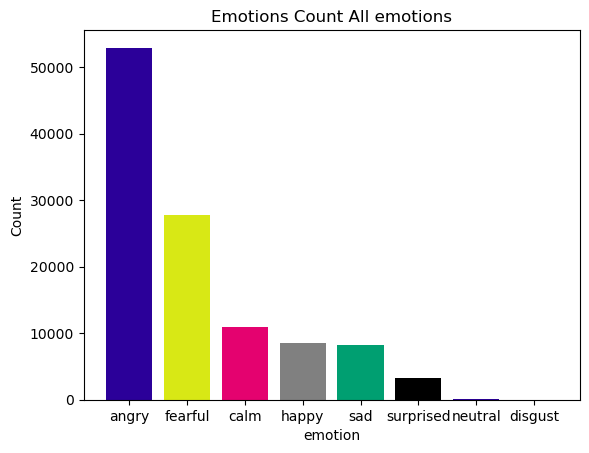

In [31]:
emotion_counts = data['emotion'].value_counts()
print(data['emotion'].unique())
print(emotion_counts)
emotions = np.array(emotion_counts.index)
colors = ['#2b0099', '#d8e815', '#e4026f', 'grey', '#009f71', 'black']
plt.bar(emotions, emotion_counts[0:len(emotion_counts)], color=colors)
plt.xlabel('emotion')
plt.ylabel('Count')
plt.title('Emotions Count All emotions')
plt.show()

In [32]:
# Define the classes to drop
classes_to_drop = ['disgust', 'neutral', 'surprised']

# Dropping the rows with the specified classes from the DataFrame
dataX = data[~data['emotion'].isin(classes_to_drop)]
dataX

,audio,emotion,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,...,Feature_609,Feature_610,Feature_611,Feature_612,Feature_613,Feature_614,Feature_615,Feature_616,Feature_617,Feature_618
2,audio_10002_processed.wav,happy,0.049805,0.069336,0.078613,0.058594,0.040039,0.028809,0.036621,0.052246,...,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007
3,audio_10003_processed.wav,happy,0.087402,0.124512,0.159668,0.147949,0.126465,0.113281,0.102051,0.096680,...,0.000276,0.000266,0.000257,0.000249,0.000242,0.000236,0.000232,0.000228,0.000225,0.000223
7,audio_10007_processed.wav,happy,0.056641,0.084473,0.116211,0.117676,0.121582,0.124512,0.115234,0.106934,...,0.002108,0.000592,0.000645,0.000280,0.000166,0.000418,0.000807,0.000590,0.000084,0.000144
9,audio_10009_processed.wav,happy,0.035645,0.049805,0.064941,0.062012,0.065430,0.069336,0.070801,0.073730,...,0.007367,0.002186,0.000164,0.002033,0.001397,0.001209,0.000174,0.000032,0.000024,0.002515
10,audio_1000_processed.wav,happy,0.059082,0.088379,0.124512,0.124023,0.139160,0.148438,0.151855,0.165527,...,0.000016,0.000016,0.000017,0.000017,0.000017,0.000017,0.000018,0.000018,0.000018,0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111693,Audio99999_processed.wav,angry,0.104980,0.122559,0.128906,0.068359,0.035645,0.026367,0.029785,0.034180,...,0.001472,0.001427,0.001383,0.001314,0.001298,0.001251,0.001218,0.001213,0.001192,0.001163
111694,Audio9999_processed.wav,fearful,0.030762,0.058105,0.086914,0.111816,0.119141,0.119629,0.130371,0.119141,...,0.007945,0.007880,0.007765,0.007605,0.007413,0.007198,0.006984,0.006783,0.006618,0.006509
111695,Audio999_processed.wav,fearful,0.086426,0.130371,0.161133,0.148438,0.124512,0.098633,0.088379,0.083496,...,0.000848,0.000737,0.000631,0.000536,0.000449,0.000377,0.000320,0.000275,0.000244,0.000226
111696,Audio99_processed.wav,calm,0.035645,0.064941,0.095703,0.111328,0.116211,0.109375,0.106445,0.101562,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002


['happy' 'calm' 'sad' 'fearful' 'angry']
emotion
angry      52896
fearful    27804
calm       10907
happy       8461
sad         8187
Name: count, dtype: int64


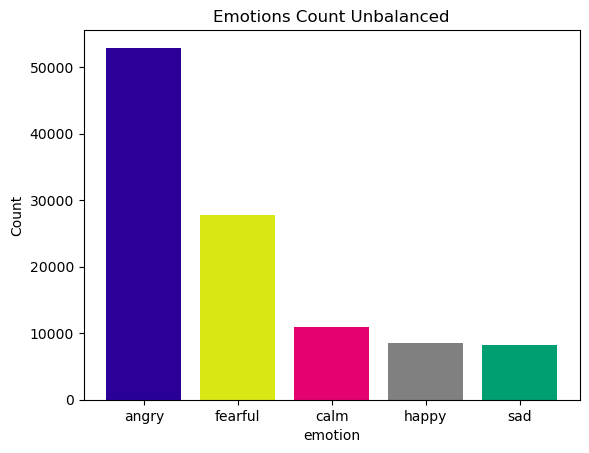

In [33]:
emotion_counts = dataX['emotion'].value_counts()
print(dataX['emotion'].unique())
print(emotion_counts)
emotions = np.array(emotion_counts.index)
colors = ['#2b0099', '#d8e815', '#e4026f', 'grey', '#009f71', 'black']
plt.bar(emotions, emotion_counts[0:len(emotion_counts)], color=colors)
plt.xlabel('emotion')
plt.ylabel('Count')
plt.title('Emotions Count Unbalanced')
plt.show()

### **Data Balance**

In [40]:
# Define the classes and their corresponding counts
classes = ['angry', 'fearful', 'calm', 'happy', 'sad']
class_counts = [52896, 27804, 10907, 8461, 8187]
target_count = 8187

# Create an empty DataFrame to store the balanced data
balanced_df = pd.DataFrame()

# Undersample each majority class to match the target count
for cls, count in zip(classes, class_counts):
    if count > target_count:
        # Undersample the majority class
        undersampled_data = resample(dataX[dataX['emotion'] == cls], n_samples=target_count, replace=False, random_state=42)
        balanced_df = pd.concat([balanced_df, undersampled_data])
    else:
        # Keep the minority class as it is
        minority_data = dataX[dataX['emotion'] == cls]
        balanced_df = pd.concat([balanced_df, minority_data])

# Output the balanced DataFrame
balanced_df

# Save the merged DataFrame to a CSV file
balanced_df.to_csv("SaudiArabic_AudioDatasetfullBalanced.csv", index=False)

In [41]:
balanced_df = pd.read_csv("SaudiArabic_AudioDatasetfullBalanced.csv")
balanced_df

,audio,emotion,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,...,Feature_609,Feature_610,Feature_611,Feature_612,Feature_613,Feature_614,Feature_615,Feature_616,Feature_617,Feature_618
0,Audio73932_processed.wav,angry,0.030762,0.042480,0.054199,0.049316,0.056152,0.062012,0.065918,0.069824,...,2.379850e-03,2.327162e-03,2.260428e-03,2.182889e-03,2.099112e-03,2.012466e-03,1.930092e-03,1.855792e-03,1.797082e-03,1.758749e-03
1,Audio2395_processed.wav,angry,0.018066,0.020996,0.022949,0.013184,0.010742,0.012695,0.015137,0.019043,...,7.473100e-03,7.252747e-03,6.988748e-03,6.692544e-03,6.380833e-03,6.066205e-03,5.772090e-03,5.511412e-03,5.307463e-03,5.175758e-03
2,Audio37330_processed.wav,angry,0.047363,0.067871,0.078613,0.065430,0.050781,0.070801,0.099609,0.116699,...,6.939211e-03,6.890416e-03,6.799501e-03,6.670937e-03,6.515316e-03,6.339666e-03,6.163313e-03,5.996353e-03,5.860758e-03,5.770413e-03
3,Audio39118_processed.wav,angry,0.051270,0.063965,0.066406,0.039551,0.021484,0.012207,0.024902,0.069336,...,5.640584e-07,5.353874e-07,5.024307e-07,4.669824e-07,4.459911e-07,4.229411e-07,4.126055e-07,4.065251e-07,3.902504e-07,3.817081e-07
4,Audio91188_processed.wav,angry,0.060059,0.067383,0.081543,0.053223,0.050781,0.053223,0.051758,0.051270,...,3.868102e-05,3.688760e-05,3.545858e-05,3.403652e-05,3.314043e-05,3.227621e-05,3.152243e-05,3.089087e-05,3.090579e-05,3.019185e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40930,Audio99901_processed.wav,sad,0.026367,0.041992,0.056641,0.059082,0.060547,0.061035,0.061523,0.067871,...,2.379855e-04,2.141941e-04,1.895257e-04,1.661869e-04,1.443901e-04,1.248583e-04,1.082467e-04,9.463019e-05,8.451039e-05,7.853900e-05
40931,Audio99934_processed.wav,sad,0.046875,0.060059,0.076172,0.075684,0.100586,0.118164,0.139160,0.156738,...,4.954922e-04,5.187065e-04,5.373114e-04,5.429070e-04,5.707793e-04,5.867698e-04,5.977821e-04,6.028381e-04,6.137489e-04,6.239579e-04
40932,Audio99945_processed.wav,sad,0.101562,0.131348,0.165527,0.143066,0.136230,0.141602,0.160645,0.180664,...,1.323542e-03,1.208244e-03,1.101542e-03,9.941455e-04,8.948334e-04,8.069532e-04,7.346974e-04,6.721675e-04,6.273116e-04,5.997958e-04
40933,Audio99958_processed.wav,sad,0.010742,0.016602,0.022461,0.023438,0.023926,0.029785,0.038574,0.039062,...,1.843493e-04,1.886207e-04,1.895012e-04,1.941181e-04,1.959295e-04,1.993724e-04,2.018001e-04,2.033916e-04,2.070309e-04,2.069686e-04


['angry' 'fearful' 'calm' 'happy' 'sad']
emotion
angry      8187
fearful    8187
calm       8187
happy      8187
sad        8187
Name: count, dtype: int64


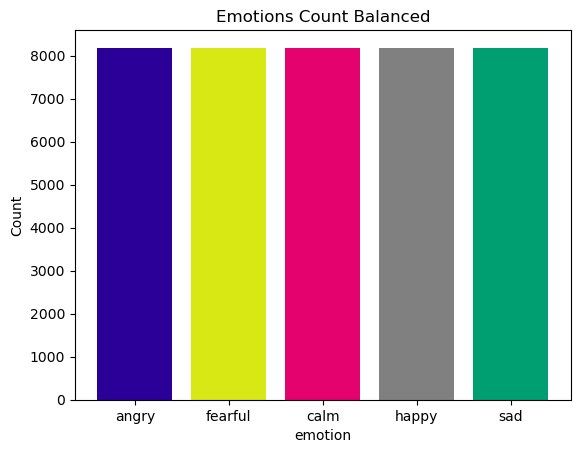

In [42]:
emotion_counts = balanced_df['emotion'].value_counts()
print(balanced_df['emotion'].unique())
print(emotion_counts)
emotions = np.array(emotion_counts.index)
colors = ['#2b0099', '#d8e815', '#e4026f', 'grey', '#009f71', 'black']
plt.bar(emotions, emotion_counts[0:len(emotion_counts)], color=colors)
plt.xlabel('emotion')
plt.ylabel('Count')
plt.title('Emotions Count Balanced')
plt.show()

In [54]:
# List to store the selected samples
selected_samples = []

# Iterate over each unique emotion category
for emotion in balanced_df['emotion'].unique():
    # Get DataFrame containing samples of the current emotion
    emotion_df = balanced_df[balanced_df['emotion'] == emotion]
    
    # Randomly select one sample from the current emotion category
    random_index = emotion_df.sample(n=1).index[0]
    selected_sample = emotion_df.loc[random_index]
    
    # Append the selected sample to the list
    selected_samples.append(selected_sample)

# Convert the list of selected samples into a DataFrame
selected_samples_df = pd.DataFrame(selected_samples)

# Display the DataFrame with one sample for each emotion category
selected_samples_df


,audio,emotion,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,...,Feature_609,Feature_610,Feature_611,Feature_612,Feature_613,Feature_614,Feature_615,Feature_616,Feature_617,Feature_618
4637,Audio72088_processed.wav,angry,0.028320,0.042480,0.060059,0.058594,0.054199,0.050781,0.045410,0.043457,...,0.007645,0.007593,0.007495,0.007356,0.007188,0.006998,0.006807,0.006626,0.006479,0.006381
8234,Audio54140_processed.wav,fearful,0.056152,0.079102,0.113770,0.129883,0.143555,0.146973,0.127930,0.091797,...,0.001445,0.001369,0.001287,0.001203,0.001122,0.001044,0.000975,0.000916,0.000871,0.000843
22924,Audio41658_processed.wav,calm,0.031250,0.050781,0.068359,0.065918,0.062500,0.050781,0.042969,0.034668,...,0.000005,0.000005,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
32617,audio_1490_processed.wav,happy,0.104492,0.157227,0.209961,0.210449,0.211426,0.208984,0.196289,0.187012,...,0.000244,0.000233,0.000223,0.000214,0.000207,0.000201,0.000196,0.000192,0.000189,0.000187
33363,Audio100035_processed.wav,sad,0.014648,0.022461,0.032227,0.031250,0.037109,0.052734,0.196777,0.356445,...,0.002122,0.002177,0.002197,0.002280,0.002331,0.002375,0.002456,0.002438,0.002502,0.002529


In [2]:
def find_audio_path(audio_filename, data_path):
    for batch_folder in os.listdir(data_path):
        batch_folder_path = os.path.join(data_path, batch_folder)
        if os.path.isdir(batch_folder_path):
            batch_number = batch_folder.replace("Batch", "").replace("Audio", "")
            for root, dirs, files in os.walk(batch_folder_path):
                for file in files:
                    if file == audio_filename:
                        audio_path = os.path.join(root, file)
                        return audio_path, int(batch_number)
    return None, None


In [3]:
# Function to copy audio files to a new folder and save as .wav
def copy_audio_files(csv_file, data_path, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Read the CSV file
    with open(csv_file, 'r') as f:
        lines = f.readlines()[1:]  # Skip header line

        for line in lines:
            # Extract filename from CSV line
            filename = line.strip().split(',')[0]
            # Find audio path
            audio_path, _ = find_audio_path(filename, data_path)
            if audio_path:
                # Copy audio file to output folder and save as .wav
                output_path = os.path.join(output_folder, f"{filename}.wav")
                shutil.copyfile(audio_path, output_path)
                #print(f"Copied {filename} to {output_path}")
            else:
                print(f"Audio file {filename} not found.")

# Paths
csv_file = "SaudiArabic_AudioDatasetfullBalanced.csv"  # Update with your CSV file path
data_path = "AudioDatasetProcessed"  # Update with the path to your audio data
output_folder = "AudioDatasetBalanced"  # Update with the path where you want to save the copied audio files

# Copy audio files
copy_audio_files(csv_file, data_path, output_folder)

In [55]:
# Iterate over each selected sample and plot waveform and display audio player
for index, row in selected_samples_df.iterrows():
    # Print name and emotion
    print(f"Emotion: {row['emotion']}")
    
    # Get the audio filename
    audio_filename = row['audio']
    data_path ="AudioDatasetProcessed"
    # Find the audio path and batch number
    audio_path, batch_number = find_audio_path(audio_filename, data_path)
    
    if audio_path is not None:
        # Load audio file using librosa
        audio_data, sample_rate = librosa.load(audio_path, sr=None)
        
        # Display audio player
        audio_player = Audio(data=audio_data, rate=sample_rate)
        display(audio_player)
        
    else:
        print(f"Audio file '{audio_filename}' not found in any batch.")

Emotion: angry


Emotion: fearful


Emotion: calm


Emotion: happy


Emotion: sad


In [56]:
def create_waveplot(data, sr, emo):
    '''
      creates waveplot from the data for the given sampling rate.
    '''
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emo), size=15)
    plt.plot(np.arange(len(data)) / sr, data)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (seconds)')
    plt.show()


In [57]:

def create_spectrogram(data, sr, emo, freq='hz'):
    '''
      creates spectrogram from the data for the given sampling rate.
      function = ['hz','log']
      output contains a spectrogram with 
                    the horizontal axis representing time,
                    the vertical axis represents frequency, 
                    and the color intensity represents the amplitude of a frequency at a certain point in time.
    '''
    #stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    plt.title('Audio Spectrogram with {} emotion [ {} ]'.format(emo, freq), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis=freq)   
    plt.colorbar(label='amplitude of frequency')
    plt.show()


In [58]:

def create_mel_spectrogram(data, sr, emo):
    '''
      creates mel-spectogram, which is perceptually relevant amplitude and frequency representation.
    '''
    mel_signal = librosa.feature.melspectrogram(y=data, sr=sr)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(label='dB')
    plt.title('Mel-Spectrogram (dB) for {} emotion'.format(emo), fontdict=dict(size=18))
    plt.xlabel('Time', fontdict=dict(size=15))


In [59]:
def plots_for_emotion(emotion):
    '''
    Creates waveplot and spectrogram for the mentioned emotion on our dataset
    '''
    for index, row in selected_samples_df.iterrows():
        if row['emotion'] == emotion:
            # Get the audio filename
            audio_filename = row['audio']
            data_path = "AudioDatasetProcessed"
            
            # Find the audio path
            audio_path, _ = find_audio_path(audio_filename, data_path)
            
            if audio_path is not None:
                # Load audio file using librosa
                audio_data, sample_rate = librosa.load(audio_path, sr=None)
                
                # Create waveplot
                create_waveplot(audio_data, sample_rate, emotion)
                
                # Create spectrogram
                create_spectrogram(audio_data, sample_rate, emotion, 'hz')
                
                # Create mel spectrogram
                create_mel_spectrogram(audio_data, sample_rate, emotion)
                
                return None

    # If the emotion is not found in the selected_samples_df
    print(f"No audio found for emotion: {emotion}")
    return None


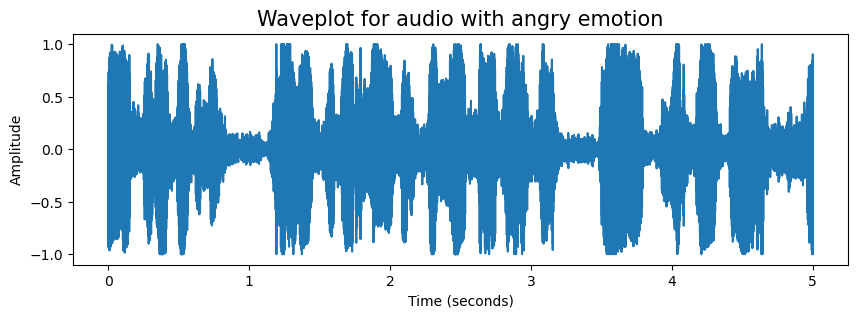

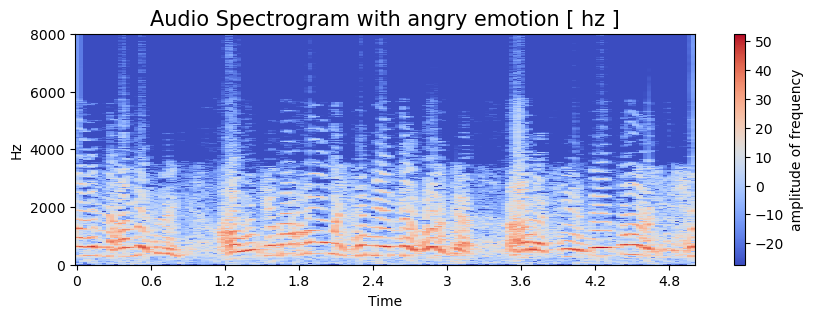

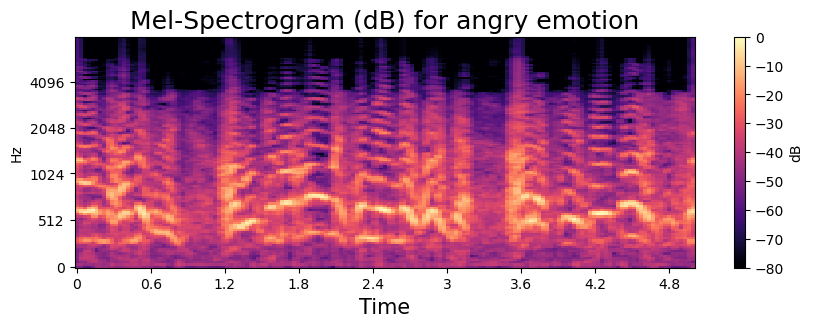

In [68]:
plots_for_emotion('angry')

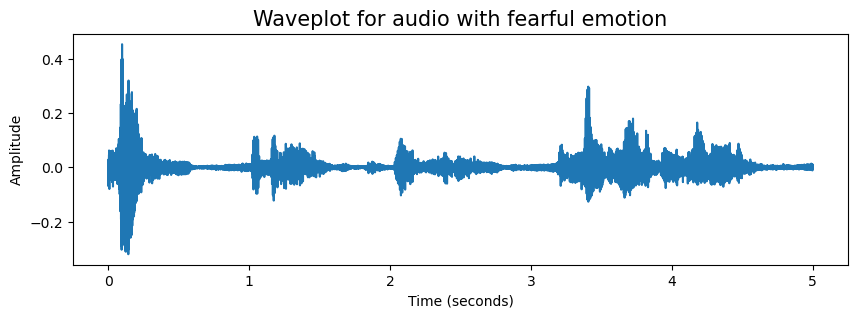

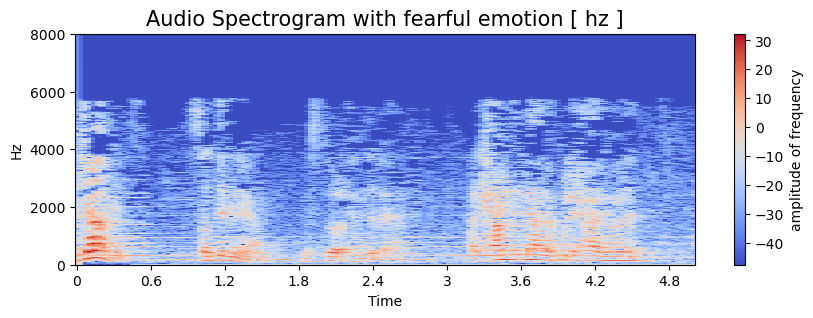

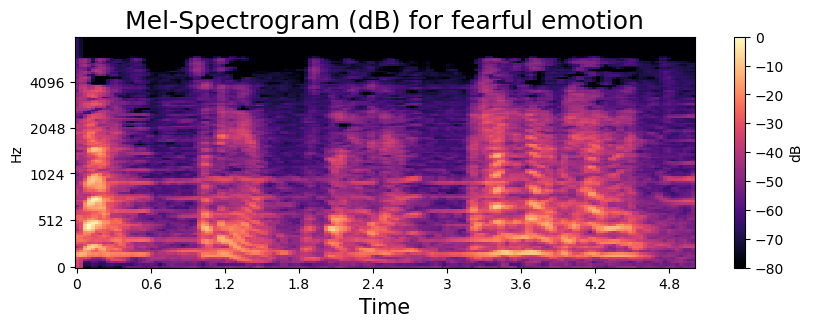

In [69]:
plots_for_emotion('fearful') 

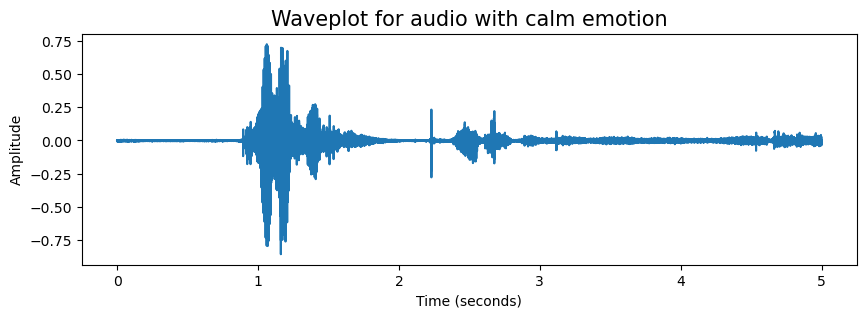

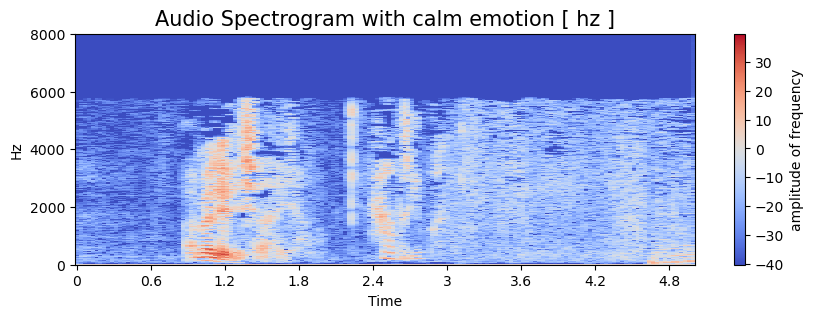

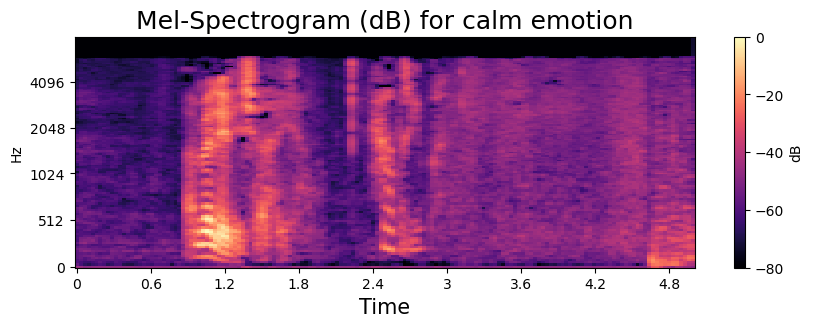

In [70]:
plots_for_emotion('calm') 

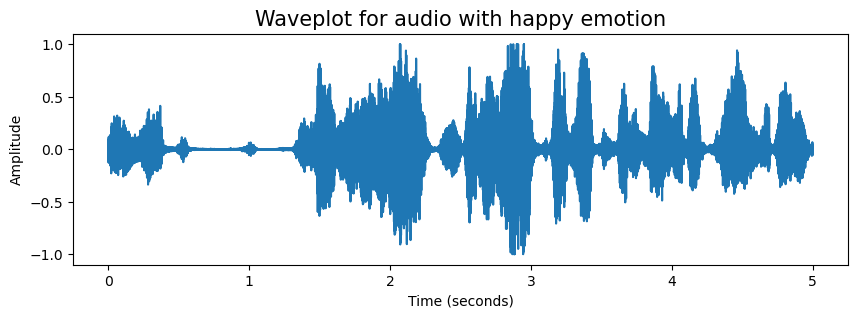

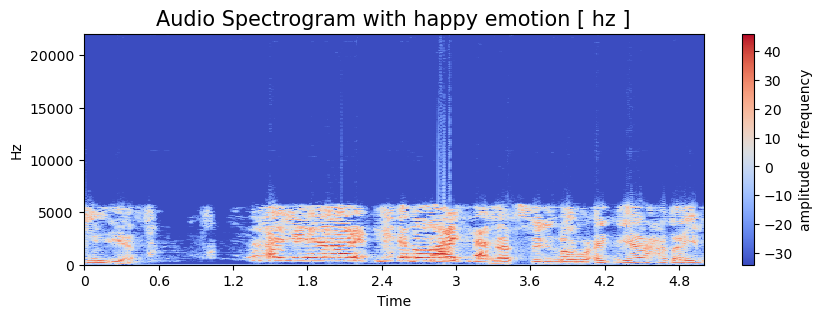

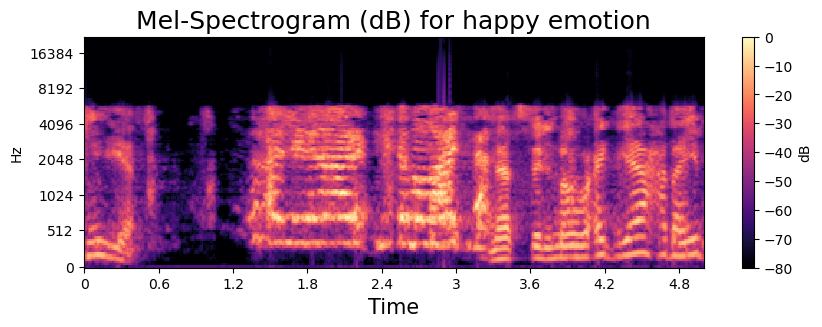

In [72]:
plots_for_emotion('happy')

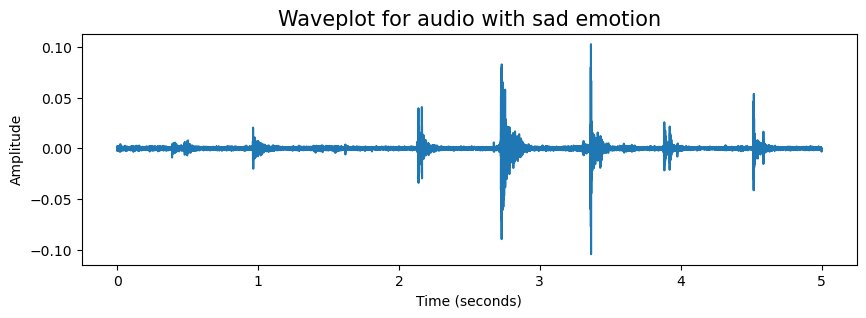

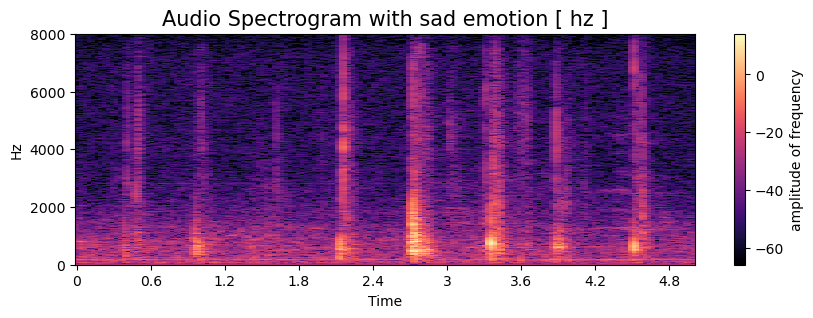

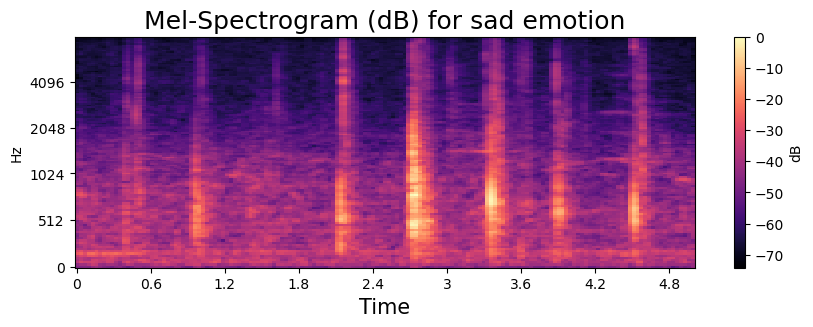

In [73]:
plots_for_emotion('sad')

# **Modeling** 

### **Speech Emotion Recognition**

In [ ]:
data=data.drop(['audio', 'Feature_470'], axis=1)

train_set, test_set = train_test_split(data, test_size=0.3, random_state=42, stratify = data['emotion'])

train_labels = data.loc[train_set.index]['emotion']
test_labels = data.loc[test_set.index]['emotion']

train_set, val_set = train_test_split(train_set, test_size=0.05, random_state=42, stratify = train_labels)

train_labels = data.loc[train_set.index]['emotion']
val_labels = data.loc[val_set.index]['emotion']

In [ ]:
# train data
train_features = train_set.drop(['emotion'], axis=1)
test_features = test_set.drop(['emotion'], axis=1)
val_features = val_set.drop(['emotion'], axis=1)


# Normalize the features using StandardScaler
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)  # Use the same scaler as for training data
test_features_scaled = scaler.transform(test_features)  # Use the same scaler as for training data

# label encode the labels
encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(train_labels)
val_labels_encoded = encoder.transform(val_labels)
test_labels_encoded = encoder.transform(test_labels)

num_classes = 5  # Number of classes in your dataset
train_labels_categorical = to_categorical(train_labels_encoded, num_classes)
val_labels_categorical = to_categorical(val_labels_encoded, num_classes)
test_labels_categorical = to_categorical(test_labels_encoded, num_classes)

# Reshape the data for CNN model
train_features_reshaped = np.expand_dims(train_features_scaled, axis=2)
val_features_reshaped = np.expand_dims(val_features_scaled, axis=2)
test_features_reshaped = np.expand_dims(test_features_scaled, axis=2)

In [ ]:
print(train_features)
print(train_labels)

In [ ]:
print(test_features)
print(test_labels)

In [ ]:
print(val_features)
print(val_labels)

In [ ]:
print("train features", train_features_scaled)
print("test features", test_features_scaled)
print("val features", val_features_scaled)

In [ ]:
print("train label", train_labels_encoded)
print("test label", test_labels_encoded)
print("val label", val_labels_encoded)

In [ ]:
print("train label", train_labels_categorical)
print("test label", test_labels_categorical)
print("val label", val_labels_categorical)

In [ ]:
print(train_features.shape)
print(test_features.shape)
print(val_features.shape)

print(train_features_reshaped.shape)
print(test_features_reshaped.shape)
print(val_features_reshaped.shape)

In [ ]:
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

print(train_labels_categorical.shape)
print(test_labels_categorical.shape)
print(val_labels_categorical.shape)

In [ ]:
CNN_train = train_features_reshaped
CNN_train_labels = train_labels_categorical
CNN_test = test_features_reshaped
CNN_test_labels = test_labels_categorical
CNN_val = val_features_reshaped
CNN_val_labels = val_labels_categorical

In [ ]:
print(CNN_train.shape)
print(CNN_train_labels.shape)
print(CNN_test.shape)
print(CNN_test_labels.shape)
print(CNN_val.shape)
print(CNN_val_labels.shape)

In [ ]:
print(CNN_train.shape)

In [ ]:
print(CNN_train)

In [ ]:
print(CNN_train)

### CNN Model

In [ ]:
earlystopping = EarlyStopping(monitor ="val_accuracy",mode = 'auto', patience = 8,restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
model=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=3,  strides=1,padding='same', activation='relu',input_shape=(CNN_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),


    L.Flatten(),
    L.Dense(1024,activation='relu'),
    L.Dense(512,activation='relu'),
    L.Dense(5,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=["accuracy"])
model.summary()

In [ ]:
history=model.fit(CNN_train, CNN_train_labels, epochs=20, validation_data=(CNN_val,CNN_val_labels), batch_size = 128, callbacks=[learning_rate_reduction, earlystopping])

In [ ]:
# Evaluate model on the test set
test_loss, test_accuracy = model.evaluate(CNN_test, CNN_test_labels, verbose=0)
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# Predict the classes for the test set
test_predictions_probs = model.predict(CNN_test)
test_predictions = np.argmax(test_predictions_probs, axis=1)
test_labels_true = np.argmax(CNN_test_labels, axis=1)

In [ ]:
# Calculate precision, recall, and F1 score for each class
report = classification_report(test_labels_true, test_predictions, target_names=encoder.classes_)
print("Classification Report:\n", report)

In [ ]:
# Calculate and print confusion matrix with normalized values
conf_matrix = confusion_matrix(test_labels_true, test_predictions)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Confusion Matrix")
plt.show()


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(CNN_test_labels, axis=1), test_predictions)
precision = precision_score(np.argmax(CNN_test_labels, axis=1), test_predictions, average='weighted')
recall = recall_score(np.argmax(CNN_test_labels, axis=1), test_predictions, average='weighted')
f1 = f1_score(np.argmax(CNN_test_labels, axis=1), test_predictions, average='weighted')

# Print the evaluation metrics
print(f'Test Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:
# Extract loss and accuracy from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# Train the model and capture the history (example with 20 epochs)
history = model.fit(
    CNN_train, CNN_train_labels,
    epochs=20,  # Adjust this as needed
    validation_data=(CNN_val, CNN_val_labels),
    batch_size=128
)

# Extract loss and accuracy from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

### **Speech To Text**

In [ ]:
%pip install --upgrade pip
%pip install --upgrade git+https://github.com/huggingface/transformers.git accelerate datasets[audio]

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
model_id = "smerchi/Arabic-Morocco-Speech_To_Text"

In [ ]:
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=False, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True,
    torch_dtype=torch_dtype,
    device=device,
)


In [ ]:

# Path to the folder containing batch folders
processed_audio_folder = "AudioDatasetBalanced"

# Initialize an empty list to store the data for all batches
all_data = []

# Iterate over each batch folder
for batch_folder in os.listdir(processed_audio_folder):
    batch_folder_path = os.path.join(processed_audio_folder, batch_folder)
    # Skip non-folder files
    if not os.path.isdir(batch_folder_path):
        continue
    
    batch_data = []

    # Iterate over all audio files in the batch folder
    for file_name in os.listdir(batch_folder_path):
        audio_file_path = os.path.join(batch_folder_path, file_name)
            
        try:
            # Use the pipeline to transcribe the audio file
            result = pipe(audio_file_path)
            
            # Append the audio file name and transcription to the batch data list
            batch_data.append({"audio": file_name, "transcription": result["text"]})
        except Exception as e:
            print(f"Error processing {audio_file_path}: {str(e)}")
            continue

    # Extend the list of data for all batches with the data for this batch
    all_data.extend(batch_data)

# Convert the list of dictionaries to a single DataFrame
df = pd.DataFrame(all_data)

# Save the DataFrame containing transcriptions for all audio files
df.to_csv("Audio_transcriptions.csv", index=False)

print("Transcriptions for all audio files saved successfully.")